### 멀티클래스에 interpret를 추가하고 VQC(output_shape=num_classes) 

# VQC 만 테스트 
1. output_shape = num_classes
2. interpret = index% num_classes
3. feature=4

In [1]:
import datetime
import time
import qiskit
import tensorflow 
import platform

datetime.datetime.now()

print('qiskit version:', qiskit.__version__)
print('tf     version:', tensorflow.__version__)
print('Python Version:',platform.python_version())
print('OS            :', platform.system())
print('코딩시간       :', time.strftime("%a %b %d %H:%M:%S %Y %Z"))
print('Copyright     : Hongsuk (hongsuk.yi@gmail.com)')

qiskit version: 1.4.2
tf     version: 2.18.0
Python Version: 3.10.0
OS            : Windows
코딩시간       : Thu Mar 20 23:59:22 2025 대한민국 표준시
Copyright     : Hongsuk (hongsuk.yi@gmail.com)


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
#sklearn
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score,classification_report
from mlxtend.plotting import plot_decision_regions

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam 

## 포팅

In [5]:
# from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import SPSA, L_BFGS_B, COBYLA
from qiskit_machine_learning.algorithms import VQC, QSVC, NeuralNetworkClassifier 
from qiskit.primitives import Sampler

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2, TwoLocal
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.utils import algorithm_globals

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df_orig = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16_L3_5m_Days20.csv")
#df = pd.read_csv("./vds16_L3_120m_Days20.csv")

## Feature selection

In [8]:
df_orig.head()

,Unnamed: 0,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate,Hour,tfi,rho,label
0,288,2017-04-03 00:00:00,30,21,9,0,58.6,1.09,0,0.123,0.044,Fast
1,289,2017-04-03 00:05:00,28,17,11,0,57.5,1.29,0,0.112,0.041,Fast
2,290,2017-04-03 00:10:00,42,33,8,1,53.1,1.53,0,0.156,0.073,Fast
3,291,2017-04-03 00:15:00,32,22,9,1,56.2,1.25,0,0.126,0.050,Fast
4,292,2017-04-03 00:20:00,22,15,7,0,52.8,1.02,0,0.081,0.034,Fast


In [9]:
# 각 라벨별 샘풀링 개수 : 200개
sample_per_label = 50

In [10]:
#각 라벨별로 200개씩 샘플링
df = df_orig.groupby('label').apply(lambda x: x.sample(n=sample_per_label, random_state=42)).reset_index(drop=True)

In [11]:
# 결과 확인
label_counts = df['label'].value_counts()
print(label_counts)

label
Fast    50
Jam     50
Slow    50
Name: count, dtype: int64


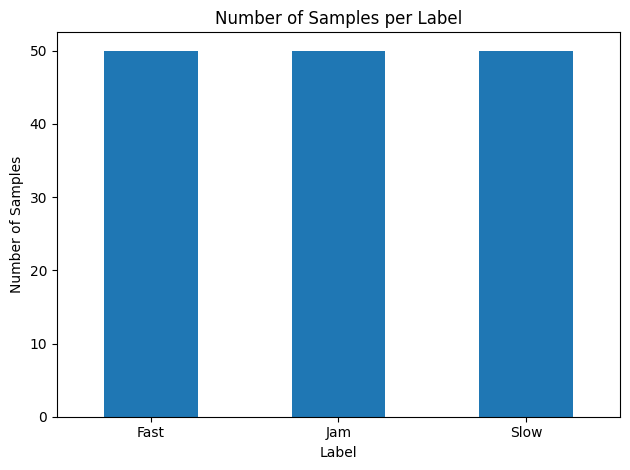

In [12]:
# pandas plot을 사용하여 bar chart 그리기
label_counts.plot(kind='bar', title='Number of Samples per Label')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0) # x축 라벨 회전 (필요에 따라 조절)
plt.tight_layout() # 레이아웃 조정
plt.show()

In [13]:
df.columns

Index(['Unnamed: 0', 'Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed',
       'OccRate', 'Hour', 'tfi', 'rho', 'label'],
      dtype='object')

<Axes: xlabel='ToVol', ylabel='Speed'>

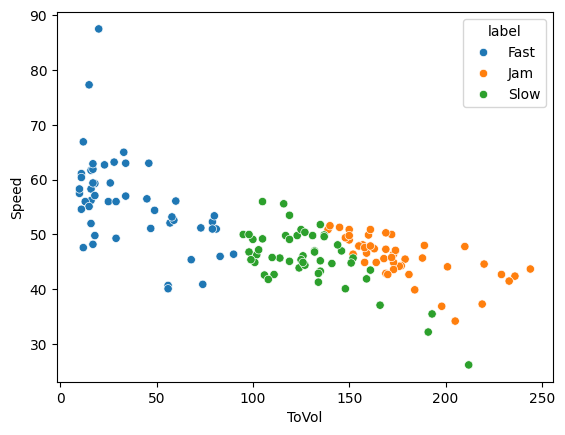

In [14]:
sns.scatterplot(df, x = 'ToVol', y = 'Speed', hue='label') 

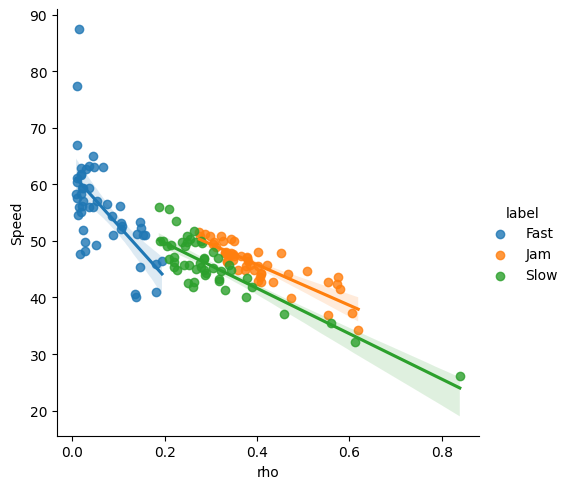

In [15]:
sns.lmplot( x = 'rho', y = 'Speed', hue='label', data=df)

# Classical classifiers 

In [16]:
df.columns

Index(['Unnamed: 0', 'Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed',
       'OccRate', 'Hour', 'tfi', 'rho', 'label'],
      dtype='object')

In [17]:
# classical SVM
X = df[['ToVol', 'Speed','Hour','rho' ]]
y = df['label']

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)
print(X_scaled[:5,:])

(150, 4)
[[-0.90015611  0.37428852  1.56524758 -0.89255489]
 [-1.34520091  0.01190683 -1.09008314 -1.2127052 ]
 [-1.52003995  1.30612716 -1.36959164 -1.39392235]
 [-0.86836719  0.43899954  1.56524758 -0.87443318]
 [-1.55182886  0.36134632 -1.50934588 -1.38788178]]


In [19]:
y_enc = LabelEncoder().fit_transform(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.20)

In [21]:
X_test2F=X_test[:, :2]
X_test2F.shape

(30, 2)

In [22]:
acc_sv=0.0
acc_ann=0.0
acc_dnn=0.0
acc_qsvc=0.0
acc_vqc=0.0

# Quantum Simulator for Quantum Classification

In [23]:
import time
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit.circuit.library import ZZFeatureMap,  RealAmplitudes
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

## 수정할 부분

In [24]:
num_classes = y.nunique()
num_features = X_train.shape[1]
#print('특성 개수  :',num_features)
#print(f"클래스 개수: {num_classes}")

feature_map = ZZFeatureMap(feature_dimension = num_features , reps=1, entanglement="linear")
#ansatz = RealAmplitudes(num_qubits = num_features , reps=4, entanglement="full")
ansatz = EfficientSU2(num_qubits = num_features , reps=3, entanglement="full")

#ansatz.decompose().draw(output="mpl", style="clifford", fold=20)
#feature_map.decompose().draw(output="mpl", fold=20)   #style="clifford",  fold=18

In [25]:
def multi_class_interpret(measured_integer):
    """측정된 정수를 num_classes으로 나눈 나머지를 클래스 인덱스로 반환"""
    return measured_integer % num_classes
    
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [26]:
sampler = Sampler()
optimizer = COBYLA(maxiter=100)

#optimizer = SPSA(maxiter=80, learning_rate=0.05, perturbation=0.05)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    output_shape=num_classes,
    interpret=multi_class_interpret  # interpret 함수 추가
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [ ]:
plt.rcParams["figure.figsize"] = (12, 6)

objective_func_vals = []
start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

#plt.plot(objective_func_vals)

In [ ]:
train_score_q4 = vqc.score(X_train, y_train)
a_vqc = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset    : {a_vqc:.2f}")

In [ ]:
y_pred = vqc.predict(X_test)

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(y_test, y_pred))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred))
predict = vqc.predict(X_test)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test}")

In [ ]:
a_svm=a_ann=a_dnn=0.1
df = pd.DataFrame({
    'models': ['SVC', 'ANN','DNN', 'VQC'],
    'accuracy':[a_svm, a_ann, a_dnn,  a_vqc]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)